In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
import math

from scipy.io import wavfile as wav
from scipy.stats import mode

### read data

In [2]:
x_test = scipy.io.loadmat('./data/eeg.mat')['x_te']
x_train = scipy.io.loadmat('./data/eeg.mat')['x_train']
y_test = scipy.io.loadmat('./data/eeg.mat')['y_te']
y_train = scipy.io.loadmat('./data/eeg.mat')['y_train']

### Functions

In [3]:
def DFT_matrix(N):
    seq_array = np.array(range(N), ndmin=2)
    DFT = np.exp(-1j*(2*math.pi*np.dot(seq_array.T,seq_array)/N))
    return DFT

def blackman_window(frame_size):
    a_0 = 0.42
    a_1 = 0.5
    a_2 = 0.08
    return (a_0 - 
            a_1 * np.cos(2 * np.pi * np.arange(frame_size)/(frame_size-1)) + 
            a_2 * np.cos(2 * np.pi * np.arange(frame_size)/(frame_size-1)) )

def STFT(x, hop_size, frame_size):
    
    DFT = DFT_matrix(frame_size)
    window = blackman_window(frame_size)
    signal_len = x.shape[0]
    zero_padding = hop_size - ((signal_len-hop_size)%hop_size)
    x = np.concatenate((x, np.zeros(hop_size)), axis=0)
    X = (x[:frame_size] * window).reshape((frame_size,1))
    start = hop_size
    
    while True:
        x_windowed = (x[start:start+frame_size] * window).reshape((frame_size, 1))
        X = np.concatenate((X, x_windowed), axis=1)
        start = int(start + hop_size)
        if signal_len < start + frame_size:
            break
    
    stft = np.dot(DFT, X)
    
    return stft

# eigen decomposition "power iteration"
def power_iteration(A):
    """
    Ideally choose a random vector to decrease the chance that our vector is orthogonal to eigen vector
    """
    b_k = np.random.rand(A.shape[0])

    for i in range(1000):
        # compute the projection of vector onto the matirx A
        b_k1 = np.dot(A,b_k)
        # normalize the projection
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1/b_k1_norm
    
    
    # rayleigh quotient in order to get the associated eigen value
    eigen_value = np.dot(b_k.T, np.dot(A, b_k))/np.dot(b_k.T,b_k)
    
    eigen_vector = np.reshape(b_k, (1, b_k.shape[0]))    
    
    # return eigen vector and eigen value
    return eigen_vector, eigen_value  

def eigen_decomposition(x):
    cov_x_eigen_values = []
    residual_cov = x
#     print(x.shape)
    for i in range(x.shape[0]):
        eigen_vector, eigen_value = power_iteration(residual_cov)
        residual_cov = residual_cov - ((eigen_value)*np.dot(eigen_vector.T, eigen_vector))
        cov_x_eigen_values.append(eigen_value)
        if i == 0:
            cov_x_eigen_vector_matrix = eigen_vector
        else:
            cov_x_eigen_vector_matrix = np.concatenate((cov_x_eigen_vector_matrix, eigen_vector), axis=0)
            
    return cov_x_eigen_values, cov_x_eigen_vector_matrix

### Extract the mu wave and create the data matrix
for the mu wave we only care about the 7.5Hz - 12.5Hz

#### Statement: 
A continuous time signal can be represented in tis samples and recovered back when sampling frequency $f_s$ is greater than or equal to twice the highest frequency component of message signal.

<center> $f_s \ge 2f_m$ </center>

In this problem, since the sampling rate is 128 HZ the maximum the frequency we can recover here is 64 Hz

Therefore we have the frame_size = 64

Hop size = 48 means than we are jumping 48 samples during the STFT inorder to retain the time domain information

We are also dropping the second half of the spectrum as it is just the complex conjugate of the upper half.

#### Data generation
only keeping the 3 - 7 rows of the STFT and them making them all a single column and this is done for all the samples

Mu wave (7.5 - 12.5Hz)

(64Hz/32)*3 = 6Hz

(64Hz/32)*7 = 14Hz

In [4]:
def data_gen(data):
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            x = data[:,j,i]
            # [:33,:] rest are complex conjugates
            # [3:8,:] mu wave frequencies
            stft_choped = STFT(x=x, hop_size=48, frame_size=64)[:33,:][3:8,:] 
            if j == 0:
                X_ = np.reshape(stft_choped, (1, stft_choped.shape[0]*stft_choped.shape[1]))
            else:
                X_ = np.concatenate((X_, np.reshape(stft_choped, (1, stft_choped.shape[0]*stft_choped.shape[1]))), axis=0)
        if i == 0:
            X = np.reshape(X_, (1, X_.shape[0]*X_.shape[1]))
        else:
            X = np.concatenate((X, np.reshape(X_, (1, X_.shape[0]*X_.shape[1]))), axis=0)
    return X.T

In [5]:
X_train = data_gen(x_train)
X_test = data_gen(x_test)
print(X_train.shape, y_train.T.shape, X_test.shape, y_test.T.shape)

(225, 112) (1, 112) (225, 28) (1, 28)


225 -> Dimensions and 112 -> Data points

### Dimensionality reduction (PCA)
#### Centering the data, Covaraince, Eigen Decompostion(Power iteration)

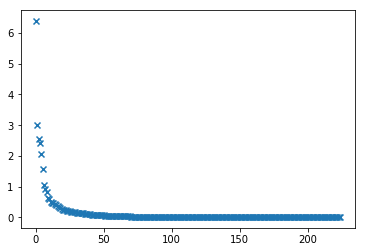

In [6]:
X_train = np.absolute(X_train - np.mean(X_train, axis=1, keepdims=True))
X_test = np.absolute(X_test - np.mean(X_test, axis=1, keepdims=True))
X_train_cov = np.cov(X_train)
eigen_values, eigen_vectors = eigen_decomposition(X_train_cov)
plt.scatter(x=[i for i in range(225)], y=eigen_values, marker="x")
plt.show()

In [11]:
Z_train = np.dot(eigen_vectors[:,:10].T, X_train)
Z_test = np.dot(eigen_vectors[:,:10].T, X_test)
print(Z_train.shape, Z_test.shape)

(10, 112) (10, 28)


#### Project the data onto random projection matrix and take the sign

In [12]:
L = 20
M = Z_train.shape[0]
A = np.random.randn(L,M)
A = A/np.linalg.norm(A, axis=1, keepdims=True)
wrapper_train = np.where(np.sign(np.dot(A, Z_train)) > 0, 1, 0)
wrapper_test = np.where(np.sign(np.dot(A, Z_test)) > 0, 1, 0)
print(wrapper_train.shape, wrapper_test.shape)

(20, 112) (20, 28)


In [9]:
def fast_KNN(X_test, k):
    predictions = []
    for test_sample in wrapper_test.T:
        indicies = (np.absolute((wrapper_train.T - test_sample)).sum(axis=1)).argsort()[:k]
        predictions.append(mode(y_train[indicies])[0][0][0])
    return np.array(predictions, dtype=int)
    
y_predicted = fast_KNN(wrapper_test, 3)
print(y_test.T[0], '\n', y_predicted)
print(1 - np.absolute(y_test.T[0] - y_predicted))
np.sum(np.absolute(y_test.T[0] - y_predicted))/len(y_test)

[1 1 2 1 1 1 2 1 2 1 1 1 2 2 1 2 1 2 1 1 2 1 1 2 1 2 2 1] 
 [1 2 1 1 1 2 1 1 1 1 2 2 2 2 2 2 1 2 1 2 2 2 1 1 1 1 2 1]
[1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1]


0.42857142857142855

In [10]:
y_train[y_train == 1].shape

(53,)

### Improvements can be made using grid search over the parameters K,L&M